In [2]:
import sklearn
import pywt
import numpy
import os
import pandas
import matplotlib.pyplot as plt
import time
import random
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics, tree

In [3]:
def haar_wavelet(img, counter = 3):
    if (counter == 0):
        return img.flatten()
    LL, (LH_, HL_, HH_) = pywt.dwt2(img, 'haar') # LL corresponds to the top left quad of the picture 
    return haar_wavelet(LL, counter - 1)

image_to_read = numpy.asarray(Image.open("CK+48/anger/S010_004_00000017.png"))
print(len(haar_wavelet(image_to_read, 1)))

576


In [4]:
images_folder = "./CK+48/"

iterations = 3
number_of_columns = {1:576, 2: 144, 3: 36}

image_data_frames = []

column_names = []
image_coeffs = []
emotions = []

for i in range(iterations):
    column_names.append([j for j in range(0, number_of_columns[i + 1])])
    image_coeffs.append([])
    emotions.append([])

for dirname, dirs, files in os.walk(images_folder):
    for filename in files:
        image_to_read = numpy.asarray(Image.open(dirname + "/" + filename))
        for i in range(iterations):
            coeffs = haar_wavelet(image_to_read, i + 1)
            image_coeffs[i].append(coeffs)
            emotions[i].append(dirname.rsplit("/",1)[-1])
    print("Loaded all " + dirname.rsplit("/",1)[-1] + " images.")

for i in range(iterations):
    image_coeffs[i] = numpy.array(image_coeffs[i])
    image_data_frames.append(pandas.DataFrame(image_coeffs[i], columns=column_names[i]))
    image_data_frames[i]["emotion"] = emotions[i]


Loaded all  images.
Loaded all anger images.
Loaded all contempt images.
Loaded all disgust images.
Loaded all fear images.
Loaded all happy images.
Loaded all sadness images.
Loaded all surprise images.


In [5]:
# Shuffling of the data_frame. Used for different output
features = []

for i in range(iterations): 
    image_data_frames[i] = image_data_frames[i].sample(frac=1, random_state = 1).reset_index(drop=True)
    features.append(image_data_frames[i].loc[:, column_names[i]])

outcome = image_data_frames[0].emotion

print(features[0])

       0      1      2      3      4      5      6      7      8      9    \
0    155.0   96.5   83.0   87.5   99.0  137.5  204.0  307.5  425.0  479.0   
1     98.5   60.0    2.0    1.5   19.0   58.5  103.0  119.0  194.5  273.0   
2     19.5    3.5    0.0    7.0   69.5  182.5  271.0  331.5  354.0  358.5   
3     76.5    9.0    0.0    0.0    0.0    2.0   16.0   48.0  101.5  151.5   
4    215.5  221.0  215.0  153.0  110.5  129.0  267.0  391.0  461.0  491.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
976  346.0  379.0  357.5  311.5  466.5  360.0  159.5  101.5  156.0  241.5   
977   62.5   21.5   26.5   93.5  198.0  334.5  393.0  429.5  488.0  507.0   
978   17.5   24.5   19.0   24.5   68.5   82.5  105.5  147.5  187.0  255.5   
979   58.0   27.0   33.0   72.0   73.0   98.5  186.0  292.0  366.5  419.0   
980  173.0   67.5   18.5  218.0  266.5  292.5  328.0  365.5  390.5  388.0   

     ...    566    567    568    569    570    571    572    573    574    

<AxesSubplot:title={'center':'Percentage of accuracy for each Classiffication Model, per amount of Features'}, xlabel='Amount of Features', ylabel='Accuracy Score (%)'>

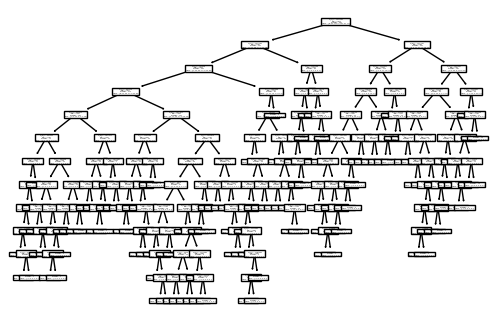

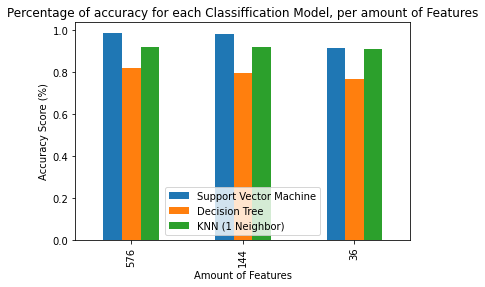

In [46]:
# Regular training and prediction.
type_of_model = 1 # 1 for SVM, 2 for Decision Tree, 3 for KNN
model_times = []
model_accuracy = []

for j in range(1,4):
    times = []
    accuracy = []

    if (j == 1):
        model = svm.SVC(kernel = "linear") # Can also be poly, but it yields a worst accuracy
    elif (j == 2):
        model = tree.DecisionTreeClassifier()
    elif (j == 3):
        model = KNeighborsClassifier(n_neighbors = 1)

    for i in range(iterations):
        x_train, x_test, y_train, y_test = train_test_split(features[i], outcome, test_size=0.3, random_state=10) # 70% training and 30% test
        start_time = time.time()
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)
        times.append(time.time() - start_time)
        accuracy.append(metrics.accuracy_score(y_test, prediction)) 
        if (j == 2) and (i == 2):
            plt.figure(dpi=100)
            tree.plot_tree(model)

    model_times.append(times)
    model_accuracy.append(accuracy)

accuracies_df = pandas.DataFrame({"Support Vector Machine": model_accuracy[0], "Decision Tree": model_accuracy[1], "KNN (1 Neighbor)": model_accuracy[2]}, index = [576, 144, 36])
accuracies_df.style
accuracies_df.plot.bar(ylabel = "Accuracy Score (%)", xlabel = "Amount of Features", title = "Percentage of accuracy for each Classiffication Model, per amount of Features")


In [25]:
k_fold = KFold(n_splits = 10)
shuffle_split = ShuffleSplit(n_splits = 10)

model_error = []
model_variance = []

model_error_ss = []
model_variance_ss = []

for j in range(1,4):
    error = []
    variances = []
    error_ss = []
    variances_ss = []

    if (j == 1):
        model = svm.SVC(kernel = "linear") # Can also be poly, but it yields a worst accuracy
    elif (j == 2):
        model = tree.DecisionTreeClassifier()
    elif (j == 3):
        model = KNeighborsClassifier(n_neighbors = 1)
    for i in range(iterations):
        list_of_errors = [1 - model.fit(features[i].iloc[train], outcome.iloc[train]).score(features[i].iloc[test], outcome.iloc[test]) for train, test in k_fold.split(features[i])]
        list_of_errors_ss = [1 - model.fit(features[i].iloc[train], outcome.iloc[train]).score(features[i].iloc[test], outcome.iloc[test]) for train, test in shuffle_split.split(features[i])]
        error.append(list_of_errors)
        error_ss.append(list_of_errors_ss)
        variances.append(numpy.var(list_of_errors))
        variances_ss.append(numpy.var(list_of_errors_ss))

    model_error.append(error)
    model_variance.append(variances)

    model_error_ss.append(error_ss)
    model_variance_ss.append(variances_ss)

error_df = pandas.DataFrame({"Support Vector Machine": model_error[0], "Decision Tree": model_error[1], "KNN (1 Neighbor)": model_error[2]}, index = [576, 144, 36])
variances_df = pandas.DataFrame({"Support Vector Machine": model_variance[0], "Decision Tree": model_variance[1], "KNN (1 Neighbor)": model_variance[2]}, index = [576, 144, 36])

error_ss_df = pandas.DataFrame({"Support Vector Machine": model_error_ss[0], "Decision Tree": model_error_ss[1], "KNN (1 Neighbor)": model_error_ss[2]}, index = [576, 144, 36])
variances_ss_df = pandas.DataFrame({"Support Vector Machine": model_variance_ss[0], "Decision Tree": model_variance_ss[1], "KNN (1 Neighbor)": model_variance_ss[2]}, index = [576, 144, 36])

error_ss_df.style
#variances_df.plot.bar(xlabel = "Amount of Features", ylabel = "Variance", title = "Model error variances in K-Fold (k = 10), based on the number of Features provided")

#variances_df.plot.bar(xlabel = "Amount of Features", ylabel = "Variance")

#print("Bootstrap Accuracies:")
#print([model.fit(features.iloc[train], outcome.iloc[train]).score(features.iloc[test], outcome.iloc[test]) for train, test in shuffle_split.split(features)])

,Support Vector Machine,Decision Tree,KNN (1 Neighbor)
576,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.14141414141414144, 0.11111111111111116, 0.030303030303030276, 0.13131313131313127, 0.11111111111111116, 0.08080808080808077, 0.202020202020202, 0.13131313131313127, 0.101010101010101, 0.0505050505050505]","[0.06060606060606055, 0.0, 0.030303030303030276, 0.0, 0.030303030303030276, 0.030303030303030276, 0.0, 0.030303030303030276, 0.030303030303030276, 0.0]"
144,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.010101010101010055, 0.0, 0.0, 0.0, 0.010101010101010055]","[0.18181818181818177, 0.14141414141414144, 0.14141414141414144, 0.1515151515151515, 0.1515151515151515, 0.1515151515151515, 0.19191919191919193, 0.1717171717171717, 0.1717171717171717, 0.18181818181818177]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.030303030303030276, 0.0, 0.0, 0.0, 0.0]"
36,"[0.030303030303030276, 0.030303030303030276, 0.0505050505050505, 0.02020202020202022, 0.0505050505050505, 0.06060606060606055, 0.08080808080808077, 0.0505050505050505, 0.030303030303030276, 0.02020202020202022]","[0.13131313131313127, 0.23232323232323238, 0.14141414141414144, 0.09090909090909094, 0.13131313131313127, 0.13131313131313127, 0.101010101010101, 0.18181818181818177, 0.14141414141414144, 0.13131313131313127]","[0.010101010101010055, 0.0, 0.030303030303030276, 0.0, 0.030303030303030276, 0.0, 0.0, 0.0, 0.0, 0.0]"


[37, 20, 67, 25, 56, 23, 67]
[[100   0   0   0   0   0   0]
 [  0  85   4   0   0   0   0]
 [  0   0  91   0   0  13   4]
 [  0   0   0  88   5   0   0]
 [  2   0   2   0  94   0   0]
 [  0   0   0  12   0  86   0]
 [  5   0   0  12   1   0  91]]
<ipython-input-37-08eaad6069b9>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-37-08eaad6069b9>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


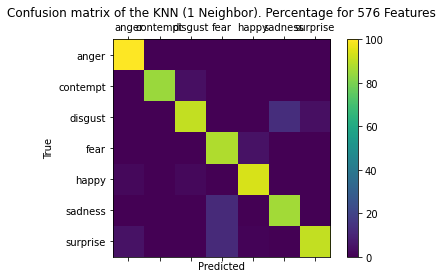

In [37]:
labels = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

j = 3

if (j == 1):
    model = svm.SVC(kernel = "linear") # Can also be poly, but it yields a worst accuracy
elif (j == 2):
    model = tree.DecisionTreeClassifier()
elif (j == 3):
    model = KNeighborsClassifier(n_neighbors = 1)

x_train, x_test, y_train, y_test = train_test_split(features[0], outcome, test_size=0.3, random_state=10) # 70% training and 30% test
model.fit(x_train, y_train)
prediction = model.predict(x_test)

matriz = metrics.confusion_matrix(y_test, prediction, labels = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"])

sumas = []
for i in range(7):
    sumas.append(sum(matriz[i]))

print(sumas)

for i in range(7):
    for j in range(7):
        matriz[i][j] = matriz[i][j] * 100 / sumas[j]

print(matriz)

fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(matriz)
if (j == 1):
    plt.title('Confusion matrix of the Linear Support Vector Machine. For 576 Features')
elif (j == 2):
    plt.title('Confusion matrix of the Decision Tree. For 576 Features')
elif (j == 3):
    plt.title('Confusion matrix of the KNN Classification. For 576 Features')
plt.title('Confusion matrix of the KNN (1 Neighbor). Percentage for 576 Features')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
